In [1]:
# python -m venv venv
# venv/Scripts/activate.bat

# !pip install jupyter numpy tensorflow tensorflow-datasets matplotlib

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt

In [3]:
train, meta = tfds.load(    # Завантажуємо датасет 'cats_vs_dogs'
    'cats_vs_dogs',         # Назва датасету
    split=['train[:100%]'], # Використовуємо 100% тренувальних даних
    with_info=True,         # Отримуємо додаткову інформацію про набір даних
    as_supervised=True      # Завантажуємо дані у форматі (зображення, мітка)
)
meta                        # Виводимо мета-інформацію про датасет

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.G61XJQ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpou0kfy8wtfds'),
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
  

In [4]:
SIZE = 224  # Встановлюємо розмір зображення (224x224 пікселів)

def resize_image(img, label):
    """
    Функція для зміни розміру зображення та його нормалізації.
    Аргументи:
      img -- зображення у форматі TensorFlow
      label -- мітка класу (0 = кіт, 1 = собака)
    Повертає:
      Змінене зображення та його мітку
    """

    img = tf.cast(img, tf.float32)  # Перетворюємо пікселі в тип float32 (замість int)
    img = tf.image.resize(img, (SIZE, SIZE))  # Масштабуємо зображення до 224x224
    img = img / 255.0  # Нормалізуємо значення пікселів до діапазону [0,1]

    return img, label  # Повертаємо оброблене зображення та його мітку

In [5]:
# Змінюємо розмір усіх зображень у тренувальному датасеті
train_resized = train[0].map(resize_image)

# Перемішуємо дані (buffer_size = 1000) та розбиваємо їх на пакети (batch_size = 16)
train_batches = train_resized.shuffle(1000).batch(16)

In [6]:
# Завантажуємо попередньо натреновану модель MobileNetV2 без верхніх (классифікаційних) шарів
base_layers = tf.keras.applications.MobileNetV2(
      input_shape=(SIZE, SIZE, 3),  # Вказуємо розмір вхідного зображення
      include_top=False  # Виключаємо верхні шари (вони не потрібні для нашої задачі)
    )
# Заморожуємо ваги базової моделі, щоб вони не оновлювались під час навчання
base_layers.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Створюємо послідовну модель нейромережі
model = tf.keras.Sequential([
    base_layers,  # Додаємо базові шари MobileNetV2 (завантажені раніше)
    GlobalAveragePooling2D(),  # Перетворюємо карти ознак у вектор середніх значень
    Dropout(0.2),  # Додаємо Dropout для регуляризації (запобігання перенавчанню)
    Dense(1)  # Вихідний шар з одним нейроном (для бінарної класифікації)
])
# Компілюємо модель з оптимізатором Adam, бінарною функцією втрат і метрикою точності
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Функція втрат для бінарної класифікації
    metrics=['accuracy']  # Оцінюємо якість моделі за допомогою точності
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
model.fit(train_batches, epochs=1)

1454/1454 ━━━━━━━━━━━━━━━━━━━━ 71s 40ms/step - accuracy: 0.9587 - loss: 0.1004


In [10]:
def process_img(img_path):
    """
    Функція для обробки зображення і виведення інформації кіт/собака.
    Аргументи:
      img_path -- str посилання на файл
    """
    # Завантажуємо зображення за допомогою load_img (отримуємо перше зображення зі списку)
    img = load_img(img_path)
    # Перетворюємо зображення на масив numpy
    img_array = img_to_array(img)
    # Змінюємо розмір зображення за допомогою функції resize_image (потрібно передати розмір)
    img_resized, x = resize_image(img_array, _)
    # Розширюємо вимірність масиву, щоб додати додаткову "пакетну" вимірність
    img_expended = np.expand_dims(img_resized, axis=0)
    # Прогнозуємо клас (кіт чи собака) для зображення, використовуючи модель
    prediction = model.predict(img_expended)[0][0]
    # Визначаємо лейбл класу залежно від прогнозованого значення
    pred_label = 'Cat' if prediction < 0.5 else 'Dog'
    # Виводимо зображення з передбаченням
    plt.figure()
    plt.imshow(img)
    plt.title(f'{pred_label} {prediction}')

Saving cat.jpg to cat.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


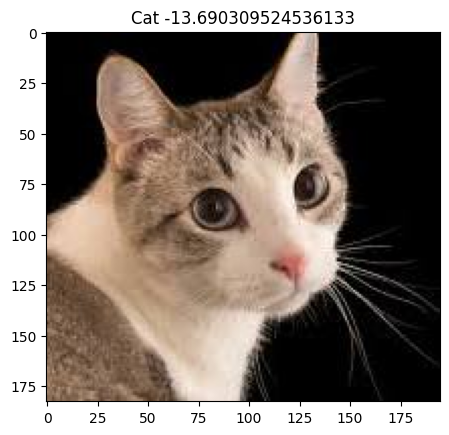

In [11]:
from google.colab import files # Для завантаження файлів у Google Colab
img_file = files.upload()      # Завантажуємо файл за допомогою Google Colab
if img_file:                   # Якщо файл завантажено, виконуємо обробку
    process_img(list(img_file.keys())[0])

In [12]:
# import tkinter as tk
# root = tk.Tk()   # Створюємо вікно для вибору файлу
# root.withdraw()  # Сховати головне вікно
# file_path = tk.filedialog.askopenfilename( # Відкриваємo вікно для вибору файлу
#       title="Виберіть файл",
#       filetypes=[("All files", "*.*")]
#     )
# if file_path: # Перевіряємо, чи вибрано файл
#     process_img(file_path)